In [ ]:
# !pip uninstall keras-nightly
# !pip uninstall -y tensorflow
# !pip install h5py==2.10.0
# !pip install tensorflow==1.15
# !pip install tensorflow-gpu==1.15.0
# !pip install keras==2.1.6

In [2]:
! wget http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz

--2022-01-01 23:28:01--  http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz
Resolving www.svcl.ucsd.edu (www.svcl.ucsd.edu)... 169.228.63.130
Connecting to www.svcl.ucsd.edu (www.svcl.ucsd.edu)|169.228.63.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740306953 (706M) [application/x-gzip]
Saving to: ‘UCSD_Anomaly_Dataset.tar.gz’

UCSD_Anomaly_Datase 100%[===================>] 706.01M  42.5MB/s    in 19s     

2022-01-01 23:28:21 (36.2 MB/s) - ‘UCSD_Anomaly_Dataset.tar.gz’ saved [740306953/740306953]



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from os import mkdir

mkdir("/content/Dataset/")
mkdir("/content/Dataset/UCSD/")

In [5]:
!tar -xzf "/content/UCSD_Anomaly_Dataset.tar.gz" -C "/content/Dataset/UCSD" 

In [6]:
mkdir("/content/Dataset/UCSD/Train/")
mkdir("/content/Dataset/UCSD/Train/npys/")

mkdir("/content/Dataset/UCSD/Test/")
mkdir("/content/Dataset/UCSD/Test/npys/")


In [7]:
from os import listdir, remove
from os.path import join, exists
import numpy as np
from PIL import Image
from scipy import signal
import cv2
from matplotlib import pyplot as plt

In [112]:
class ModelConfig:
    TRAIN_DATASET_PATH ="/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
    TEST_DATASET_PATH = "/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
    SINGLE_TEST_PATH = "/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test014"
    BATCH_SIZE = 1
    EPOCHS = 10
    MODEL_WEIGHTS_DIRECTORY = "/content/drive/MyDrive/Dataset/UCSD/Train"
    COMBINE_MODEL_PATH = "GAN_combine_model.hdf5"
    GENERATOR_MODEL_PATH = "GAN_generator_model.hdf5"
    DISCRIMINATOR_MODEL_PATH = "GAN_discriminator_model.hdf5"
    AUTOENCODER_MODEL_PATH = "autoencoder_model.hdf5"
    SEQUENCE_SIZE = 16
    H = 256
    W = 256
    C = 1
    STRIDE = range(1, 3)
    TRAIN_SAMPLE_NPZ_DIRECTORY = "/content/Dataset/UCSD/Train/npys"
    TEST_SAMPLE_NPZ_DIRECTORY = "/content/Dataset/UCSD/Test/npys"

In [113]:
def save_4D_sample_npz(sample, directory, index):
    file_name = "smaple_{}.npz".format(index)
    file_path = join(directory, file_name)
    np.savez(file_path, sample)
    return file_name

In [114]:
def clear_npz_directory(directory_path):
    for f in listdir(directory_path):
        remove(join(directory_path, f))
        
clear_npz_directory(ModelConfig.TRAIN_SAMPLE_NPZ_DIRECTORY)  

In [115]:
def load_npz_4D_sample(directory, file_name):
    file_path = join(directory, file_name)
    dict_data = np.load(file_path)
    data = dict_data['arr_0']
    return data

In [116]:
def save_samples_npz(sample, npz_files_directory, num_sample):
    file_name = save_4D_sample_npz(sample, npz_files_directory, num_sample)
    return file_name

In [117]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Input, Conv3D, Conv3DTranspose,
                                     ConvLSTM2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K



def encoder(X_input):
    # encoder    
    X = Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='same',activation='tanh')(X_input)

    X = Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh')(X)

    X = ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True)(X)

    bottleneck = ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True)(X)
    
    return bottleneck

    
def decoder(bottleneck):
    # decoder
    X = ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5, name="decoder_layer")(bottleneck)

    X = Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh')(X)

    X = Conv3DTranspose(filters=ModelConfig.C,kernel_size=(11,11,1),strides=(4,4,1),padding='same',activation='sigmoid')(X)

    return X

def AutoEncoderModel(X_input):
    autoencoder = Model(X_input, decoder(encoder(X_input)), name='AutoEncoderModel')
    return autoencoder

In [118]:
def load_model(weights_path):
  X_input = Input(shape=(ModelConfig.H,ModelConfig.W,ModelConfig.SEQUENCE_SIZE,ModelConfig.C))
  autoencoder = AutoEncoderModel(X_input)
  autoencoder.load_weights(weights_path)
  return autoencoder

In [119]:
autoencoder = load_model("/content/drive/MyDrive/Dataset/LAST_RESULTS_UCSD_UCF/Weights/UCSD/UCSD_autoencoder_model_LSTM.hdf5")

In [120]:
def get_single_test(test_file_path, extension="tif"):
    segments = []
    frames = []
    num_segments = 0
    list_dir = listdir(test_file_path)
    for c in sorted(list_dir):
        img_path = join(test_file_path, c).replace("\\", '/')
        if str(img_path)[-3:] == extension:
            img = Image.open(img_path).resize((ModelConfig.H, ModelConfig.W))
            img = np.array(img, dtype=np.float32) / 255.0
            frames.append(img)
            if len(frames) == ModelConfig.SEQUENCE_SIZE:
              segments.append(save_samples_npz(frames, ModelConfig.TEST_SAMPLE_NPZ_DIRECTORY, num_segments))
              num_segments += 1
              frames.clear()
    return segments

In [121]:
segments_frames_list = get_single_test(ModelConfig.SINGLE_TEST_PATH)
segments_frames_list

['smaple_0.npz',
 'smaple_1.npz',
 'smaple_2.npz',
 'smaple_3.npz',
 'smaple_4.npz',
 'smaple_5.npz',
 'smaple_6.npz',
 'smaple_7.npz',
 'smaple_8.npz',
 'smaple_9.npz',
 'smaple_10.npz',
 'smaple_11.npz']

In [122]:
import matplotlib.pyplot as plt

def evaluate(model, segments_frames_list):    
    segments_len = len(segments_frames_list)
    sz = 0
    num_segments = 0
    sequences = []
    reconstructed_sequences = []
    sample_reconstruction_cost = []
    while sz < segments_len:
        minibatch = np.array([load_npz_4D_sample(ModelConfig.TEST_SAMPLE_NPZ_DIRECTORY,
                                                 segments_frames_list[sz])])
        minibatch = minibatch.reshape((-1, minibatch.shape[1], ModelConfig.H, ModelConfig.W, ModelConfig.C))
        X = np.transpose(minibatch, (0,2,3,1,4))
        reconstructed = model.predict(X)
        reconstructed = np.transpose(reconstructed, (0,3,1,2,4))
        sz+=1

        for index in range(len(minibatch)):
          sequences.extend(minibatch[index])
          reconstructed_sequences.extend(reconstructed[index])
          org_frame = minibatch[index]
          rec_frame = reconstructed[index]
          diff = [np.linalg.norm(np.subtract(org_frame[i], rec_frame[i])) for i in range(0,len(org_frame))]
          sample_reconstruction_cost.extend(diff)
    

    sample_reconstruction_cost = np.array(sample_reconstruction_cost)
    sa = (sample_reconstruction_cost - np.min(sample_reconstruction_cost)) / np.max(sample_reconstruction_cost)    
    sr = 1.0 - sa
    sequences = np.array(sequences)
    reconstructed_sequences = np.array(reconstructed_sequences)
    
    return sequences, reconstructed_sequences, sr

In [123]:
segments_frames_list = get_single_test(ModelConfig.SINGLE_TEST_PATH)


In [124]:
sequences, reconstructed_sequences, sr = evaluate(autoencoder, 
                                                  segments_frames_list)
sr

array([0.9900074 , 0.99920624, 1.        , 0.98960966, 0.98747724,
       0.99026275, 0.9796777 , 0.97980666, 0.9849563 , 0.97540385,
       0.9697945 , 0.98365885, 0.97694004, 0.97340125, 0.9638535 ,
       0.9608252 , 0.9738808 , 0.9676264 , 0.966832  , 0.9813741 ,
       0.9794055 , 0.9872099 , 0.9817436 , 0.98382205, 0.9777553 ,
       0.97846526, 0.9762312 , 0.9647702 , 0.97264564, 0.9611474 ,
       0.96140784, 0.9612295 , 0.9555002 , 0.9577899 , 0.9512104 ,
       0.95052063, 0.9432286 , 0.9518782 , 0.9493503 , 0.9396692 ,
       0.92706794, 0.93342066, 0.9281973 , 0.91737336, 0.91660535,
       0.9123509 , 0.9261452 , 0.92539626, 0.9245529 , 0.9285455 ,
       0.93155867, 0.9492326 , 0.948195  , 0.95298123, 0.94829357,
       0.93097675, 0.93107146, 0.94390374, 0.93621725, 0.93554103,
       0.93863   , 0.92821354, 0.9223409 , 0.9274072 , 0.94623834,
       0.9474684 , 0.94192165, 0.93693393, 0.9422025 , 0.94130564,
       0.9402789 , 0.9503299 , 0.9390938 , 0.95178175, 0.94984

In [125]:
def plot_regularity_score(sr):
  plt.plot(sr)
  plt.ylabel('regularity score Sr(t)')
  plt.xlabel('frame t')
  plt.show()

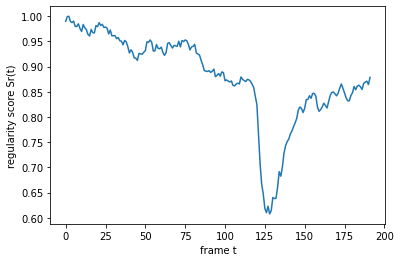

In [126]:
plot_regularity_score(sr)

In [130]:
seq_num = 125

In [131]:
result = []
result.append(sequences[seq_num].reshape((ModelConfig.H, ModelConfig.W)))
result.append(reconstructed_sequences[seq_num].reshape((ModelConfig.H, ModelConfig.W)))
result = np.array(result)

In [132]:
result.shape


(2, 256, 256)

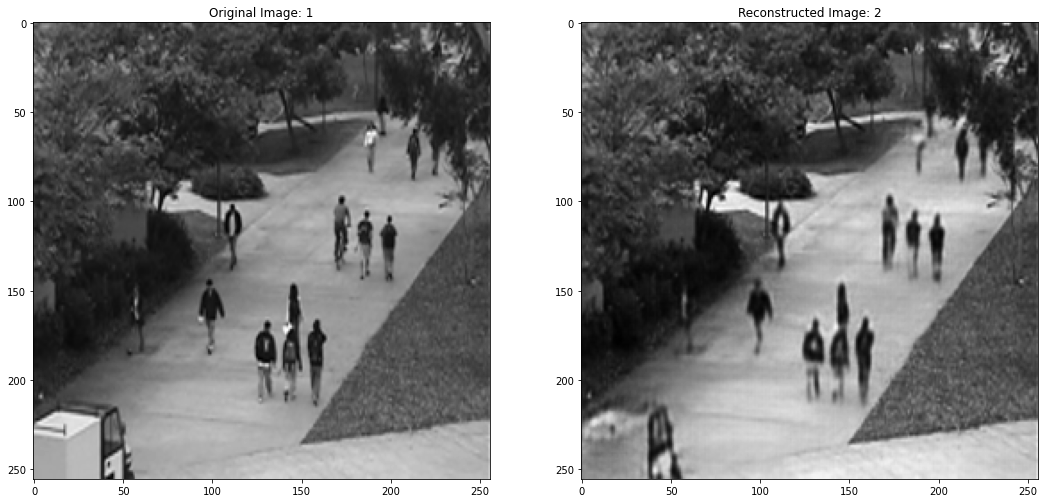

In [133]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,20))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(result[i], cmap="gray")
    if i % 2 == 0:
      plt.title('Original Image: {}'.format(i+1))
    else:
      plt.title('Reconstructed Image: {}'.format(i+1))

plt.show()

In [134]:
from scipy import signal
from PIL import Image

In [135]:
def fig2data(fig):
    fig.canvas.draw ( )
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    data = data.reshape((h, w, 3))
    return data

In [136]:
def plot(img, fig, axes,output, diff, H, threshold):
    (ax0, ax1, ax2,ax3) = axes
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')
    
    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest') 
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')   
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')  
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    
    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.1) 

    plt.axis('off')
    data = fig2data ( fig )
    return Image.fromarray(data)

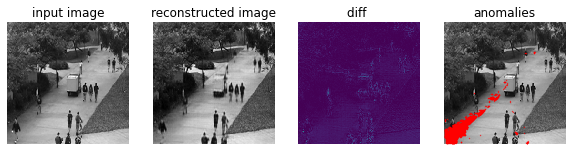

In [137]:
threshold = 4*255
counter = 0

fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
frame_result = [] 

i = 0
for seq, rec_seq in zip(sequences, reconstructed_sequences):
    counter = counter + 1
    img = seq*255
    output = rec_seq*255
    diff = np.abs(output-img)

    tmp = diff[:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')

    res = plot(img[:,:,0], fig, (ax0, ax1, ax2,ax3), output[:,:,0], diff[:,:,0],
               H, threshold)
    
    frame_result.append(res)


In [138]:
# !git clone https://github.com/matterport/Mask_RCNN.git

In [139]:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [140]:
# cd Mask_RCNN

In [141]:
# !python setup.py install

In [142]:
# !pip show mask-rcnn

In [143]:
from mrcnn import utils
import mrcnn.model as modellib 
from mrcnn import visualize

In [144]:
from mrcnn.config import Config

class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80

mrcnn_config = TestConfig()
mrcnn_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [145]:
from mrcnn.model import MaskRCNN

rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())

In [146]:
cd /content/

/content


In [147]:
rcnn.load_weights('mask_rcnn_coco.h5', by_name=True)

In [148]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [149]:
def get_object_centroid(img, objects_binary_mask):
  objects_binary_mask = objects_binary_mask.astype(int)
  centroid = []
  for c in range(objects_binary_mask.shape[2]):
    tmp = (objects_binary_mask[:,:,c]*255).astype('uint8')
    M = cv2.moments(tmp)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    img_temp = np.zeros(img.shape)
    centroid.append([cX, cY])
    img_temp = img * tmp.reshape(tmp.shape[0], tmp.shape[1], 1)
    plt.imshow(img_temp)
    plt.scatter(cX, cY)
    plt.show()
      
  return centroid

In [150]:
def draw_image_with_boxes(img, boxes, class_ids, scores):
     plt.clf()
     ax = plt.gca()
     ax.imshow(img.reshape(img.shape[0], img.shape[1]), cmap="gray")
     for i in range(0, len(boxes)):
          y1, x1, y2, x2 = boxes[i]
          width, height = x2 - x1, y2 - y1
          rect = plt.Rectangle((x1, y1), width, height, fill=False, color='red')
          ax.add_patch(rect)
          txt = class_names[class_ids[i]]+ " : " + str(scores[i])
          ax.annotate(txt, (x1, y1+2), fontsize=4)
     plt.axis('off')

In [151]:
def detect_anomaly_objects(res, img, points, with_centroid_visualization=False):
  centroid = []
  custom_mask = []
  rois = []
  class_ids = []
  scores = []
  
  objects_flag =  [False for i in range(len(res['rois']))]
  has_mask = False
  for p in points:
    for index in range(0, len(objects_flag)):

      if objects_flag[index]:
        break

      y1, x1, y2, x2 = res['rois'][index]
      if (p[0] >= x1 and p[0] <= x2) and (p[1] >= y1 and p[1] <= y2):
        objects_flag[index] = True
        rois.append(res['rois'][index])
        class_ids.append(res['class_ids'][index])
        scores.append(res['scores'][index])
        custom_mask.append(res['masks'][:,:,index])
        has_mask = True

  rois = np.array(rois)
  class_ids = np.array(class_ids)
  scores = np.array(scores)
  custom_mask = np.array(custom_mask)

  custom_mask = custom_mask.reshape((res['masks'].shape[0], res['masks'].shape[1], -1))
  # visualize.display_instances(img, rois, class_ids=class_ids, masks=custom_mask,
  #                             class_names=class_names, scores=scores, ax=plt.gca()) 
  draw_image_with_boxes(img, rois, class_ids, scores)
  if with_centroid_visualization:
    centroid = get_object_centroid(img, custom_mask, with_centroid_visualization) 

  if not has_mask:
    custom_mask = np.zeros((img.shape[0], img.shape[1], 1))

  return centroid, custom_mask

In [152]:
def fig2data():
    fig = plt.gcf()
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    data = data.reshape((h, w, 3))
    return data


In [153]:
def detect_objects(res, img, points, with_visualization=True,
                   with_centroid_visualization=False):
  
  custom_mask = np.zeros((img.shape[0], img.shape[1], 1))
  fig = plt.gcf()
  if len(points) > 0:
      centroid, custom_mask = detect_anomaly_objects(res, img, points, with_centroid_visualization)
  else:
    # visualize.display_instances(img, np.array([]), np.array([]), np.array([]), 
    #                             class_names, np.array([])) 
    fig = draw_image_with_boxes(img, np.array([]), np.array([]), np.array([]))
    if with_centroid_visualization:
      centroid = get_object_centroid(img, res['masks'])   
  data = fig2data()

  custom_mask = np.array(custom_mask, dtype=np.int8)
  objs_mask = custom_mask[:,:,0].reshape(custom_mask.shape[0], custom_mask.shape[1])

  if custom_mask.shape[2] > 1:
    for i in range(1, custom_mask.shape[2]):
      objs_mask = (objs_mask | custom_mask[:,:,i].reshape(custom_mask.shape[0], custom_mask.shape[1]))

  return Image.fromarray(data), np.array(objs_mask)

In [157]:
def annotate_anomaly_object(sequences, reconstructed_sequences):
  frame_result = []
  mask_result = []
  threshold = 4*255
  for seq, rec_seq in zip(sequences, reconstructed_sequences):
  #for i in range(80,85):
    #seq=sequences[i]
    #rec_seq=reconstructed_sequences[i]

    img = seq*255
    output = rec_seq*255
    diff = np.abs(output-img)

    tmp = diff[:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')

    image_rgp = cv2.cvtColor(seq,cv2.COLOR_GRAY2RGB)*255
    results = rcnn.detect([image_rgp], verbose=0)

    res = results[0]
    y_list, x_list = np.where(H > threshold)
    points = [(x,y) for x,y in zip(x_list,y_list)]
    fig_data, custom_mask = detect_objects(res, img, points,
                                           with_visualization=True, 
                                           with_centroid_visualization=False)
    frame_result.append(fig_data)
    mask_result.append(custom_mask)

  return frame_result, np.array(mask_result)

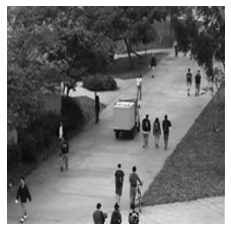

In [158]:
frames_result, frames_mask = annotate_anomaly_object(sequences, reconstructed_sequences)

In [159]:
frames_result[0].save("frames_result.gif", save_all=True, 
                      append_images=frames_result[1:], duration=100, loop=0)

In [162]:
def get_ground_truth_images(test_file_path, extension="bmp"):
    frames = []
    num_segments = 0
    for c in sorted(listdir(test_file_path)):
        img_path = join(test_file_path, c).replace("\\", '/')
        if str(img_path)[-3:] == extension:
            img = Image.open(img_path).resize((ModelConfig.H, ModelConfig.W))
            img = np.array(img, dtype=np.int8)
            frames.append(img)            
    return np.array(frames)

In [181]:
def load_ground_truth(test_file_path):
  gt_test_file_path = test_file_path+"_gt"
  if not exists(gt_test_file_path):
    return None
  segments = get_ground_truth_images(gt_test_file_path, extension="bmp")
  return segments

In [182]:
gt_segments = load_ground_truth(ModelConfig.SINGLE_TEST_PATH)

In [183]:
def get_mask_number_object(mask):
  mask = mask.astype(np.uint8)
  _, thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
  output = cv2.connectedComponentsWithStats(thresh, cv2.CV_8U, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output
  return numLabels-1

In [184]:
get_mask_number_object(gt_segments[100])


1

In [186]:
def get_intecection_number_object(y_hat_mask, gt_mask):
  intercect = y_hat_mask & gt_mask
  intercect = np.array(intercect, np.uint8)
  _, thresh = cv2.threshold(intercect, 0, 255, cv2.THRESH_BINARY)
  output = cv2.connectedComponentsWithStats(thresh, cv2.CV_8U, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output
  return numLabels-1

In [187]:
get_intecection_number_object(frames_mask[0], gt_segments[91])

0

In [188]:
def get_y(y_hat_masks, gt_mask):
  y_true = []
  y_hat = []
  for index in range(0, len(y_hat_masks)):
    y_true.append(get_mask_number_object(gt_mask[index]))
    y_hat.append(get_intecection_number_object(y_hat_masks[index], gt_mask[index]))
  return y_true, y_hat
  

In [191]:
y_true, y_hat = get_y(frames_mask, gt_segments)
y_true, y_hat

([2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [199]:
def calculate_sample_accuracy_per_frame(y_hat, y_true):
  return sum(np.array(y_hat)/np.array(y_true))/len(y_hat)*100

In [200]:
calculate_sample_accuracy_per_frame(y_hat, y_true)

11.458333333333332